In [19]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import os
from natsort import natsorted
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Preprocess Data

## Display Image

In [21]:
def display_image(inp_tensor, img_pos=0):
    """
    img_pos of 0 will get the middle image. img_pos -1 will get the img BEFORE the middle img, 1 will get the img AFTER the middle img, and so on.
    inp_tensor will be of shape [c, h, w]
    """
    num_channels = inp_tensor.shape[0]
    num_imgs = num_channels // 3
    middle_idx = num_imgs - 1 - (num_imgs // 2)
    selected_idx = middle_idx + img_pos

    img = inp_tensor[3*selected_idx:3*selected_idx+3]
    img = torch.permute(img, (1, 2, 0))
    img = img[:, :, [2, 1, 0]]
    plt.imshow(img)

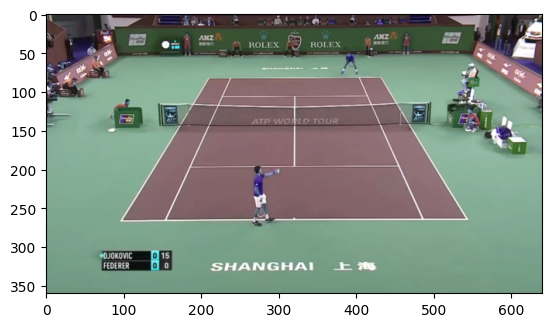

In [35]:
display_image(first_three[0], 0)

## Dataset

In [22]:
class TennisDataset(Dataset):
    def __init__(self, base_path, frames=1, resize=(360, 640), transform=None):
        self.base_path = base_path
        self.frames = frames
        self.resize = resize
        self.transform = v2.Compose([
            v2.Resize((resize[0], resize[1])),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])

        frames_ahead = frames // 2
        frames_behind = frames - 1 - frames_ahead

        data = []
        for game_name in natsorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in natsorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                # get labels, format their filenames, and combine them into one
                label_file_path = os.path.join(clip_path, 'Label.csv')
                label = pd.read_csv(label_file_path)
                label = label[frames_behind:-frames_ahead][:]
                label = label.fillna(-1)
                label = label.rename(columns={"file name": "filename"})
                label['filename'] = game_name + '_' + clip_name + '_' + label['filename']
                data.extend(label.values.tolist())

        self.labels = pd.DataFrame(data, columns=['filename', 'visibility', 'x-coordinate', 'y-coordinate', 'status'])
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgs = []
        label = self.labels.iloc[idx]
        
        filename = label.iloc[0]
        first_sep = filename.index("_")
        second_sep = filename.index("_", first_sep + 1)
        game_name = filename[:first_sep]
        clip_name = filename[first_sep+1:second_sep]
        img_num = int(filename[second_sep+1:filename.index(".")])

        frames_behind = self.frames - 1 - (self.frames // 2)
        start = img_num - frames_behind
        for i in range(start, start + self.frames):
            img_name = str(i).zfill(4) + ".jpg"
            img_path = os.path.join(self.base_path, game_name, clip_name, img_name)
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        imgs = torch.cat(imgs, dim=0)

        # label consists of 'visibility', 'x-coordinate', 'y-coordinate', and 'status'
        label = torch.tensor([label.iloc[1:]], dtype=torch.float32)

        img_name = str(img_num).zfill(4) + ".jpg"
        path_gt = os.path.join(self.base_path, game_name, clip_name, img_name)
        gt_output = self.get_output(path_gt)

        return imgs, gt_output, label

    def get_output(self, path_gt):
        img = cv2.imread(path_gt)
        img = cv2.resize(img, (self.resize[1], self.resize[0]))
        img = img[:, :, 0]
        img = np.reshape(img, self.resize[1] * self.resize[0])
        return img

## Hyperparameters

In [45]:
import torch.nn as nn

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
epochs = 500

In [26]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

batch_size = 2

## Dataloader

In [23]:
from torch.utils.data import DataLoader

In [24]:
base_path = './datasets/tennis'

In [25]:
full_dataset = TennisDataset(base_path, frames=3)

In [27]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

In [28]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Model

In [30]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.block(x)
        return x

class TrackNet(torch.nn.Module):
    def __init__(self, frames=1, out_channels=256):
        super().__init__()
        self.out_channels = out_channels
        self.VGG16 = nn.Sequential(
            ConvBlock(in_channels=frames*3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=256, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512)
        )
        self.DeconvNet = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=512, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=256, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=128, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            ConvBlock(in_channels=64, out_channels=self.out_channels)
        )
        # self.softmax = nn.Softmax(dim=1)
        
        self.init_weights()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.VGG16(x)
        x = self.DeconvNet(x)
        x = x.reshape(batch_size, self.out_channels, -1)
        return x

    # def evaltest(self, x):
    #     batch_size = x.size(0)
    #     x = self.VGG15(x)
    #     x = self.DeconvNet(x)
    #     x = self.softmax(x)
    #     return x

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                # nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

In [31]:
model = TrackNet(frames=3, out_channels=256).to(device)

## Heatmap

In [ ]:
def get_ball_xy(heatmap, threshold):
    binary_heatmap = int(heatmap * 255)
    

## Train

In [33]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for iter_id, (imgs, gt_output, label) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(imgs)
        gt_output = gt_output.long()
        loss = criterion(outputs, gt_output)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"iter: {iter_id}, loss: {loss.item()}")

    return running_loss / len(train_loader)

## Validate

In [70]:
model.eval()
imgs, gt_output, label = next(iter(val_dataloader))
print(f"imgs shape: {imgs.shape}")
print(f"gt_output shape: {gt_output.shape}")
print(f"label shape: {label.shape}")

with torch.no_grad():
    outputs = model(imgs)
    softmax_layers = nn.Softmax(dim=1)(outputs)
    print(softmax_layers.shape)
    depth_indices = torch.argmax(softmax_layers, dim=1)
    print(depth_indices.shape)
    print(depth_indices[1].shape)

    # channels range is [0, 255] (incluvisve)
    # heatmap = nn.threshold()

    one_item = depth_indices[1]
    # TODO: apply the following for the ENTIRE batch
    # heatmap = nn.Threshold(threshold=127, value=255)(one_item)
    heatmap = torch.where(one_item >= 128, torch.tensor(255), torch.tensor(0))
    # print(heatmap)
    # heatmap = torch.reshape(heatmap, (360, 640))
    print(heatmap.shape)
    # plt.imshow(heatmap, cmap='gray')
    # cv2.imshow(heatmap)

model.train();

C:\Users\alexr\AppData\Local\Temp\ipykernel_9052\1661618803.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor([label.iloc[1:]], dtype=torch.float32)


imgs shape: torch.Size([2, 9, 360, 640])
gt_output shape: torch.Size([2, 230400])
label shape: torch.Size([2, 1, 4])
torch.Size([2, 256, 230400])
torch.Size([2, 230400])
torch.Size([230400])
torch.Size([230400])


In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    total_dist = 0.0
    with torch.no_grad():
        for iter_id, (imgs, gt_output, label) in enumerate(val_loader):
            outputs = model(imgs)
            softmax_layers = nn.Softmax(dim=1)(outputs)
            depth_indices = torch.argmax(softmax_layers, dim=1)
            

## Training Loop

In [122]:
train(model, train_dataloader, optimizer, criterion, device)

C:\Users\alexr\AppData\Local\Temp\ipykernel_10220\1661618803.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor([label.iloc[1:]], dtype=torch.float32)


iter: 0, loss: 5.797020435333252
iter: 1, loss: 5.7056169509887695
iter: 2, loss: 5.507966041564941


KeyboardInterrupt: 